<center><h1><font face="vollkorn" color=navy> Price Errors Between Invoices and POs</font></h1><center>
<center><h2> Are we systematically overpaying? </h2></center>
<p>
<img src="http://www.berkeley.edu/brand/img/logos/primarylogo.png" style="float: center; width: 75%; margin-left: 20%;">
<p style="clear: both;">
<center><h1><font face="vollkorn" color=navy>Contributors:</center>
<p>
<h2>Andrew G. Clark</h2>

<font face="vollkorn"><p><b>Purpose:</b><br>
This book explores the accuracy of pricing invoiced to UCSF and UC Berkeley versus the Purchase Order. 

<p><b>Background:</b> <br>
UCSF issues Purchase Orders (binding legal contracts) to suppliers as a "promise" to pay for goods and services. The PO serves as official notice to the supplier of the goods/services we wish to buy, along with the price we are authorizing for payment, and any other terms and conditions we require.  It is generally expected that the supplier will either fill the purchase order and send UCSF the goods/services ordered or will call UCSF to identify a problem with the order.  
<p>
In Febuary 2015, UCSF BearBuy Operations was notified by a key stakeholder that they belived we were being systematically over-invoiced.  That is to say, suppliers were issuing invoices to UCSF for dollar amounts greater than the PO authorized.  As a result, this was causing a great deal of work for this stakeholder who was carefully reconciling her budgets.

<p><b>Assumptions:</b><br>
+ PO Line Extended Price vs. Invoice Line Extended Price is correct identifier of price error.
+ The invoice full extract from BearBuy(s) is the right dataset to use.
+ BearBuy PO number is a reasonable approximation for time.

<p><b>To Do:</b><br>
+ I should identify the blankets and then mark them in the initial data set in a new column.

<font face="vollkorn"><h2>Read in data and pre-process it</h2>
<p>The BearBuy Invoice extract includes a number of columns unnecessary for this analysis.  This section of code reads in the data, creates a list of important columns, then removes all columns not on the list.

In [1]:
%pylab inline
import pandas as pd
import numpy as np

#Read in the data
RawData = pd.read_csv('/home/analyst/Desktop/invoices/all.csv', low_memory=False, thousands=',')


#The UCSF file has different headers to describe the same data.  Rename UCSF Headers to match UCB Headers.
try:
    RawData.rename(columns={'PO #':'PO No', 
                            'Extended Price1':'Invoice Line Extended Price',
                            'Extended Price2':'PO Line Extended Price',
                            'PO Line #':'PO Line No',
                            'Voucher #':'Voucher No',
                            'Invoice System Creation Date':'Invoice System Created Date',
                            'Home Department Name':'Department Name',
                            'Invoice Type':'Voucher Type'
                           }, inplace=True)
except:
    pass

#Eliminate columns not used in the analysis [uses the Berkeley file name convention]
keep_columns = ['PO No',
                'PO Line No',
                'PO Line Unit Price',
                'PO Line Extended Price',
                'Supplier Name',
                'Manufacturer',
                'Department Name',
                'Invoice Owner',
                'Item Type',
                'Form Type',
                'Voucher No',
                'Voucher Source',
                'Voucher Type',
                'Invoice Line Unit Price',
                'Invoice Line Extended Price',
                'Voucher Status',
                'Workflow Status',
                'Line Status'
               ]

invoices = RawData[keep_columns];

Populating the interactive namespace from numpy and matplotlib


<font face="vollkorn"><h2>Filter the data and add PO features</h2>
<p>The dataset contains far more types of documents than "regular" invoices.  As such some additional filtering is required.  Specifically:
* Filter non-PO data: We eliminate anything not starting with a "B".
* Filter unprocessed invoices: The data includes a host of invoices which have not been approved by campus accounts payable.  These are removed.
* Filter credit memos: We constrain our focus to just invoices and not credit memos or other documents in the data.
* Filter Blanket POs: Blanket POs are PO Lines that are used to pay for multiple invoices.  There is no apriori specified buy when the Blanket is created, rather, these are authorizations for campus officials to spend fixed dollar amounts with a specific supplier.  This typically makes sense when administration wants to frontload all approvals and authorizations to better streamline the buying activity of researchers, faculty, and other staff.  


In [2]:
#filter out all of the non-invoice invoices...
invoices_filtered = invoices[(invoices['PO No'].str.startswith('B')) &
                              (invoices['Voucher Status'] != 'Rejected') &
                              (invoices['Invoice Line Extended Price'] > 0) &
                              (invoices['Voucher Type'] != 'Credit Memo') &
                              (invoices['Workflow Status'] == 'Complete') &
                              (invoices['Line Status'] == 'Approved')]

#Summarize the data by PO Number and calculate some features
summary = invoices_filtered.groupby(['PO No','PO Line No','Supplier Name']).agg({'PO Line Extended Price': lambda x: x.unique(),
                                                                                 'Invoice Line Extended Price': np.sum,
                                                                                 'Voucher No': lambda x: len(x.unique())
                                                                                 })

#Set the datatypes for the fields to float
summary['Invoice Line Extended Price'] = summary['Invoice Line Extended Price'].replace(',','').astype(float)
summary['PO Line Extended Price'] = summary['PO Line Extended Price'].replace(',','').astype(float)

#Calculate the features of interest
summary['PO Amount Used'] = summary['Invoice Line Extended Price'] / summary['PO Line Extended Price']
summary['PriceDiff'] = summary['Invoice Line Extended Price'] - summary['PO Line Extended Price'] 
summary['PercentDiff'] = summary['PriceDiff'] / summary['PO Line Extended Price']


##What do the non-blanket PO price errors look like?

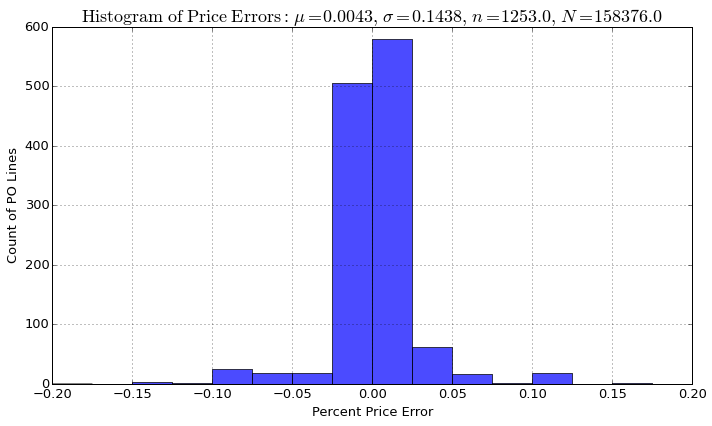

In [17]:
import numpy as np
#import seaborn as sns

#Filter the data to those PO Lines unlikely to be blankets
f = summary[(summary['Voucher No'] <= 1) &
                  (summary['PO Amount Used'] >= .70) &
                  (summary['PriceDiff'] != 0) &
                  (summary['PriceDiff'] >= -.5) &
                  (summary['PriceDiff'] <= .5)
                  ].reset_index();

#Calculates the total base including those with zero price problems
tot = summary[(summary['Voucher No'] <= 1) &
                  (summary['PO Amount Used'] >= .70) &
                  (summary['PriceDiff'] >= -.5) &
                  (summary['PriceDiff'] <= .5)
                  ].reset_index();

#Describe the data and set the key paramaters to variables
stats = f['PercentDiff'].describe()
mean = stats[1]
count = stats[0]
stdev = stats[2]


minbin = -.2
maxbin = .2
binwidth = .025

f.hist(column='PercentDiff', bins=np.arange(minbin, maxbin + binwidth, binwidth), range=(-0.2,0.2), 
       alpha=.7, figsize=(10,6),histtype='bar',xlabelsize=13, ylabelsize=13);
plt.xlabel('Percent Price Error', fontsize=13);
plt.ylabel('Count of PO Lines', fontsize=13);
plt.title(r'$\mathrm{Histogram\ of\ Price\ Errors:}\ \mu='+ str(np.round(mean,4)) +
          ',\ \sigma='+ str(np.round(stdev,4))+
          ',\ n='+str(f['PO Line No'].describe()[0])+
          ',\ N='+str(tot['PO Line No'].describe()[0])+
          '$', fontsize=18);
plt.tight_layout()
plt.show()


#sns.distplot(f.PercentDiff)

#tot.to_csv('/home/analyst/Desktop/invoices/tot.csv')
#example formatting code
#print Suppliers.to_string(formatters={'PriceDifference':'${:,.0f}'.format,
#                                      'PO Line Extended Price':'${:,.0f}'.format,
#                                      'PercentDifference':'{:,.2f}%'.format})

##Analyze by Supplier

<font face="vollkorn">

In [16]:
#Create a binary indicator of price error
tot['PriceError'] = tot['PercentDiff'] != 0

#Summerize the price error by total lines 
SupplierSummary = tot.groupby(['Supplier Name','PriceError']).agg({'PO Line No': 'count'}).unstack().fillna(0)

#Format the price error table more intuitively and change the name of the columns
SupplierSummary.columns = SupplierSummary.columns.droplevel(0)
SupplierSummary = SupplierSummary.reset_index()
SupplierSummary = SupplierSummary.rename(columns = {SupplierSummary.columns[1]:'NotError',
                                                    SupplierSummary.columns[2]:'IsError'
                                                    })

#Calculate the percent of total lines in Error
SupplierSummary['PercentError'] = SupplierSummary['IsError'] / (SupplierSummary['NotError'] + SupplierSummary['IsError'])

#Print out the table in descending format
SupplierSummary.sort('IsError', ascending=False).head(10)



PriceError,Supplier Name,NotError,IsError,PercentError
1133,CASCADE ORTHOPEDIC SUPPLY INC,1112,351,0.239918
4730,SIGMA-ALDRICH INC,6856,88,0.012673
4546,SANTA CRUZ BIOTECHNOLOGY INC,467,60,0.113852
5534,"VWR INTERNATIONAL, INC.",11697,56,0.004765
3069,LIFE TECHNOLOGIES CORPORATION,4985,45,0.008946
3947,"PATTERSON DENTAL SUPPLY, INC",1389,41,0.028671
586,ASSOCIATED SERVICES CO,246,35,0.124555
4333,"REMEL, INC",54,31,0.364706
1163,CDW-GOVERNMENT INC.,2668,24,0.008915
1690,DIGI-KEY CORPORATION,174,23,0.116751


In [32]:
#We bring back the invoices_filtered data and mark each error'd PO with the appropriate designation
NonBlankets = invoices_filtered[invoices_filtered['PO No'].isin(tot['PO No'])]

#Which Items Seem to have the most problems
NonBlankets['PriceError'] = NonBlankets['Invoice Line Extended Price'] - NonBlankets['PO Line Extended Price'] 
NonBlankets['IsError'] = NonBlankets['PriceError'] != 0

ItemType = NonBlankets.groupby(['Item Type','IsError']).agg({'PriceError':'count'}).unstack()

ItemType.columns = ItemType.columns.droplevel(0)
ItemType = ItemType.reset_index()
ItemType = ItemType.rename(columns = {ItemType.columns[1]:'NotError',
                                      ItemType.columns[2]:'IsError'
                                      })
ItemType

IsError,Item Type,NotError,IsError
0,Contract NonCatalogItem,4550,139
1,NonCatalog Product,53718,3201
2,Punch-out Product,45250,1012
3,SQ Hosted Product,53792,811
